In [27]:
%cd /content/drive/My Drive/segmentation
import functools
import numpy as np
import file_utils
from matplotlib import pyplot as plt, cm

/content/drive/My Drive/segmentation


# Setup GPUs

In [28]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.3.1


In [29]:
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name != "/device:GPU:0":
    raise SystemError("GPU device not found!")
print(f"Found GPU at `{gpu_device_name}`")

Found GPU at `/device:GPU:0`


# Load volume


In [30]:
dir = "/content/drive/My Drive/segmentation/"

# this is just a little trick to group the 
# filenames in an object and have the auto completion works

class filename:
  train_img_path = dir + "tomo.preprocessed.PA66GF30_trans3_x__0_pag.raw"
  train_info_path = dir + "tomo.preprocessed.PA66GF30_trans3_x__0_pag.raw.info" 
  train_labels_path = dir + "tomo.labels.PA66GF30_trans3_x__0_pag.raw"

  val_img_path = dir + "tomo.val.preprocessed.PA66GF30_trans3_x__0_pag.raw"
  val_info_path = dir + "tomo.val.preprocessed.PA66GF30_trans3_x__0_pag.raw.info" 
  val_labels_path = dir + "tomo.val.labels.PA66GF30_trans3_x__0_pag.raw"

class labels:
  matrix = 0
  fiber = 1
  hole = 2

dimensions = (500, 500, 500)
dtype = "uint8"

# prefill the function `HST_read` to clean up the code
hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

In [31]:
train_volume = hst_read(filename.train_img_path)
train_labels = hst_read(filename.train_labels_path)

val_volume = hst_read(filename.val_img_path)
val_labels = hst_read(filename.val_labels_path)

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


# Plot slices and labe

In [32]:
def tightsubplots(n, m, w, h):
  fig, axs = plt.subplots(n, m, figsize=(w, h), sharex=True, sharey=True)
  fig.set_tight_layout(True)
  return fig, axs

(0.0, 500.0, 0.0, 500.0)

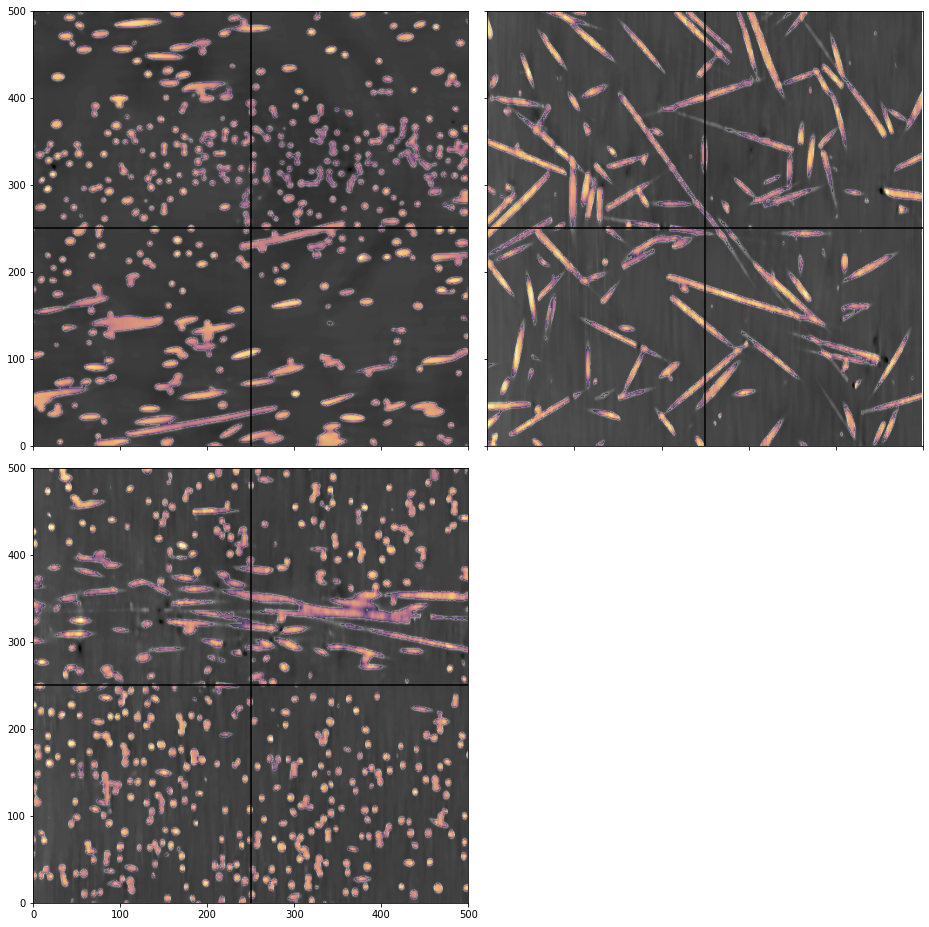

In [33]:
fig, axs = tightsubplots(2, 2, 13, 13)

volume = train_volume
mask = (~ (train_labels == labels.fiber)).astype(int)

axs[0, 0].imshow(volume[:, :, 250], cmap=cm.gray, interpolation=None)
axs[0, 1].imshow(volume[250, :, :], cmap=cm.gray)
axs[1, 0].imshow(volume[:, 250, :], cmap=cm.gray)

volume_masked = np.ma.masked_where(mask, volume)
axs[0, 0].imshow(volume_masked[:, :, 250], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[0, 1].imshow(volume_masked[250, :, :], cmap=cm.inferno, interpolation=None, alpha=0.5)
axs[1, 0].imshow(volume_masked[:, 250, :], cmap=cm.inferno, interpolation=None, alpha=0.5)

axs[0, 0].hlines(250, 0, 500)
axs[0, 1].hlines(250, 0, 500)
axs[1, 0].hlines(250, 0, 500)
axs[0, 0].vlines(250, 0, 500)
axs[0, 1].vlines(250, 0, 500)
axs[1, 0].vlines(250, 0, 500)
axs[0, 0].axis((0, 500, 0, 500))
axs[0, 1].axis((0, 500, 0, 500))
axs[1, 0].axis((0, 500, 0, 500))
axs[1, 1].axis(False)

# Data Sequences

In [34]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
%autoreload 2
import volume_img_segm
from volume_img_segm import VolumeImgSegmSequence

In [36]:
slice_size = 224
batch_size = 32

train_generator = VolumeImgSegmSequence(
    source_volume=train_volume,
    label_volume=train_labels,
    labels=[0, 1, 2],
    axes=(2,),
    batch_size=batch_size,
    shuffle=True,
    n_geometric_augmentations=0,
    crop_size=slice_size,
)

val_generator = VolumeImgSegmSequence(
    source_volume=val_volume,
    label_volume=val_labels,
    labels=[0, 1, 2],
    axes=(2,),
    batch_size=batch_size,
    shuffle=False,
    n_geometric_augmentations=0,
    crop_size=slice_size,
)

In [37]:
train_generator.on_epoch_end()
x, y = val_generator[0]
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(32, 224, 224, 1) (32, 224, 224, 3)
<dtype: 'float32'> <dtype: 'float32'>


# Model

In [38]:
%autoreload 2
import modular_unet
from tensorflow.keras.utils import plot_model

In [39]:
model_name = "dryrun-00"
input_shape = (slice_size, slice_size, 1)

model = modular_unet.u_net(input_shape, nb_filters_0=8, output_channels=3, name=model_name)

In [40]:
model.summary()

Model: "dryrun-00"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 224, 224, 1)  0           input_2[0][0]                    
__________________________________________________________________________________________________
encoder-block-0-conv1 (Separabl (None, 224, 224, 8)  25          dropout_18[0][0]                 
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 224, 224, 8)  32          encoder-block-0-conv1[0][0]      
__________________________________________________________________________________________

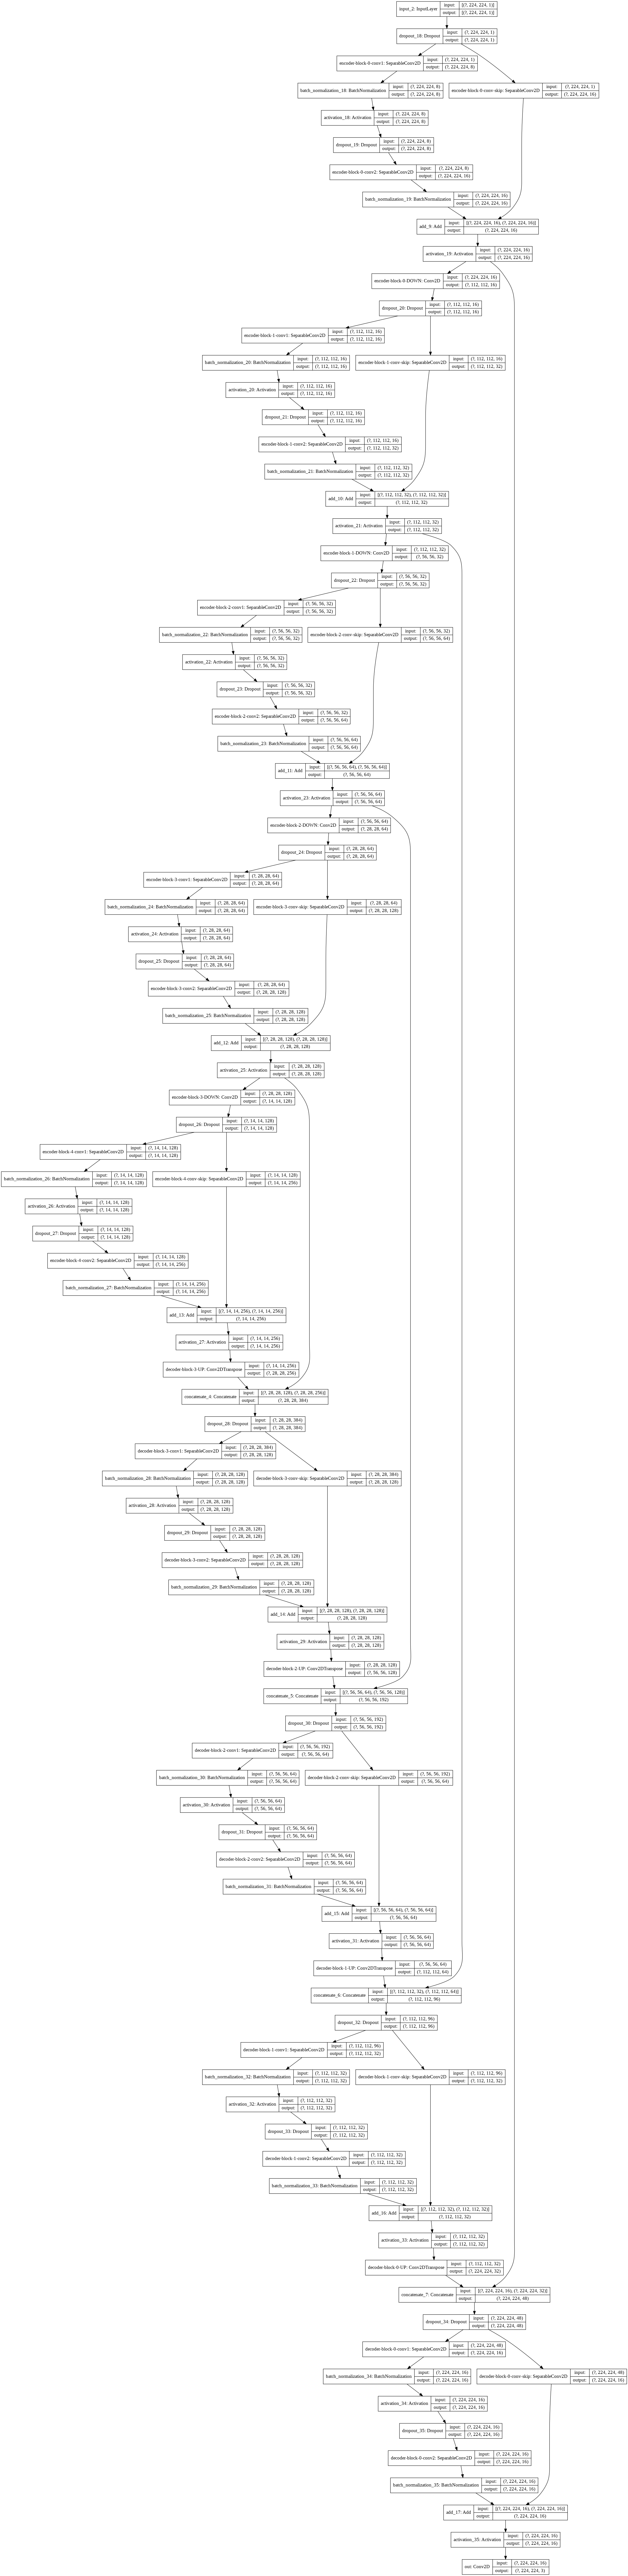

In [41]:
plot_model(model, show_layer_names=True, show_shapes=True)

# Compilation

In [23]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    CSVLogger,
    Callback,
    TerminateOnNaN,
)
from tensorflow.keras.losses import categorical_crossentropy

lr = 3e-3
n_epochs = 50
loss_func = categorical_crossentropy

optimizer = Adam(lr=lr)

autosave_model_file_path = dir + f"{model_name}-autosaved.hdf5"
logger_file_path = dir + f"{model_name}-logger.csv"
print(autosave_model_file_path, logger_file_path, sep='\n')

cb = [
    ModelCheckpoint(
        autosave_model_file_path, 
        monitor="val_loss", 
        verbose=0, 
        save_best_only=True, 
        mode="auto",
    ),
    CSVLogger(logger_file_path, separator=",", append=False),
    TerminateOnNaN(),
    # ReduceLROnPlateauBacktrack(
    #     model,
    #     autosave_model_file_path,
    #     monitor="val_loss",
    #     factor=0.5,
    #     patience=5,
    #     verbose=1,
    #     mode="auto",
    #     min_delta=0,
    #     min_lr=1e-5,
    # ),
]

/content/drive/My Drive/segmentation/dryrun-00-autosaved.hdf5
/content/drive/My Drive/segmentation/dryrun-00-logger.csv


In [24]:
# unique, counts = np.unique(train_labels, return_counts=True)
# class_freqs = dict(zip(unique, counts))
# total = sum(class_freqs.values())
# class_freqs = {k: v / total for k, v in class_freqs.items()}
# class_freqs
# class_freqs_inv = {k: 1. / v for k, v in class_freqs.items()}
# class_freqs_inv
# import tensorflow as tf
# from tensorflow.python.keras import backend as K
# weights = [class_freqs_inv[i] for i in range(len(class_freqs_inv))]

# def weighted_cross_entropy(y_true, y_pred):
#   Kweights = K.constant(weights)
#   if not K.is_keras_tensor(y_pred):
#     y_pred = K.constant(y_pred)
#   y_true = K.cast(y_true, y_pred.dtype)
#   return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * y_pred, axis=-1)

In [25]:
model.compile(loss=categorical_crossentropy, optimizer=optimizer)

# Training


In [26]:
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    validation_steps=5,
    epochs=n_epochs,
    callbacks=cb,
    verbose=1,
    use_multiprocessing=False,
    validation_freq=3,
    # class_weight=class_freqs_inv, 
)

Epoch 1/50
62/62 [==============================] - 80s 1s/step - loss: 0.1035
Epoch 2/50
62/62 [==============================] - 80s 1s/step - loss: 0.0259
Epoch 3/50
62/62 [==============================] - 82s 1s/step - loss: 0.0220 - val_loss: 0.4868
Epoch 4/50
62/62 [==============================] - 80s 1s/step - loss: 0.0194
Epoch 5/50
62/62 [==============================] - 80s 1s/step - loss: 0.0178
Epoch 6/50
62/62 [==============================] - 83s 1s/step - loss: 0.0172 - val_loss: 0.2363
Epoch 7/50
62/62 [==============================] - 80s 1s/step - loss: 0.0157
Epoch 8/50
62/62 [==============================] - 80s 1s/step - loss: 0.0149
Epoch 9/50
62/62 [==============================] - 83s 1s/step - loss: 0.0138 - val_loss: 0.1857
Epoch 10/50
62/62 [==============================] - 80s 1s/step - loss: 0.0135
Epoch 11/50
62/62 [==============================] - 80s 1s/step - loss: 0.0127
Epoch 12/50
62/62 [==============================] - 81s 1s/step - loss:

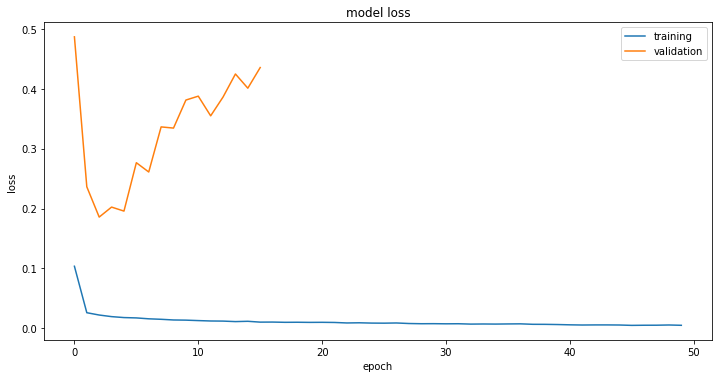

In [44]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 111)

In [72]:
import pandas as pd
if "val_loss" in history.history:
    del history.history["val_loss"]
history_df = pd.DataFrame({**history.history, **{"epochs": history.epoch}})
history_df.to_csv(dir + f"{model_name}-history.csv", index=False)

In [74]:
model.save(dir + model_name)

INFO:tensorflow:Assets written to: /content/drive/My Drive/segmentation/dryrun-00/assets
